In [1]:
!pip install agentpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 478.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.7/778.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00


In [2]:
import agentpy as ap
import random
import matplotlib.pyplot as plt
import json

In [3]:
class Vehicle(ap.Agent):
    def setup(self, id=0):
        self.id = id

        # Inicializamos si esta parado en falso
        self.stopped = False
        self.changed_dir = False

        # Seleccionamos uno de los cuatro carriles
        self.carril = random.choice([0, 1, 2, 3])

        # Seleccionamos la dirección que tomará el Vehiculo en la intersección
        self.direction = random.choice(["Recto", "Derecha"])

        # Indica si un coche ha cruzado la intersección o no
        self.crossed = False

        # Asignar posiciones iniciales basadas en la dirección y carril
        if self.carril == 0:
            self.position = (-5, 0)
            self.current_direction = (1, 0)

        elif self.carril == 1:
            self.position = (-1, 5)
            self.current_direction = (0, -1)

        elif self.carril == 2:
            self.position = (5, 1)
            self.current_direction = (-1, 0)

        elif self.carril == 3:
            self.position = (0, -5)
            self.current_direction = (0, 1)

    # Los coches ven el coche que tienen enfrente o el semaforo que tienen enfrente
    def see(self, traffic_lights, vehicles):
        for light in traffic_lights:
            if self.carril == light.carril:
                closest_light = light
                break

        # Buscamos el vehiculo mas cercano
        vehicle_in_front = None
        min_distance = float('inf')  # Iniciar con una distancia infinita
        for vehicle in vehicles:
            if vehicle.carril == self.carril and vehicle != self:
                # La posición relativa depende del carril y la dirección del movimiento
                if self.carril == 0 and vehicle.position[0] > self.position[0]:  # Movimiento hacia el Este
                    distance = vehicle.position[0] - self.position[0]
                elif self.carril == 1 and vehicle.position[1] < self.position[1]:  # Movimiento hacia el Sur
                    distance = self.position[1] - vehicle.position[1]
                elif self.carril == 2 and vehicle.position[0] < self.position[0]:  # Movimiento hacia el Oeste
                    distance = self.position[0] - vehicle.position[0]
                elif self.carril == 3 and vehicle.position[1] > self.position[1]:  # Movimiento hacia el Norte
                    distance = vehicle.position[1] - self.position[1]
                else:
                    continue  # Si el vehículo no está en frente, ignorarlo

                # Actualizar el vehículo en frente si este está más cerca
                if distance < min_distance:
                    min_distance = distance
                    vehicle_in_front = vehicle

        return closest_light, vehicle_in_front

    def action(self, closest_light, vehicle_in_front):
        stop_for_vehicle = vehicle_in_front and self.calculate_distance_to(vehicle_in_front) <= 1

        stop_for_light = closest_light.state == "red" and self.calculate_distance_to(closest_light) <= 1 and self.at_intersection() == False

        if stop_for_light:
            # print(f"Vehiculo en {self.position} parado por semaforo en rojo")
            self.stopped = True
            return

        if stop_for_vehicle:
            # print(f"Vehiculo en {self.position} parado por vehiculo enfrente")
            self.stopped = True
            return

        # Si hemos entrado en la intersección ponemos crossed a True
        if self.at_intersection():
            if not self.changed_dir:
                if self.direction == "Derecha" and not self.crossed:
                    # Cambia la dirección actual 90 grados a la derecha
                    if self.current_direction == (1, 0):  # Este
                        self.current_direction = (0, -1)  # Sur
                    elif self.current_direction == (0, -1):  # Sur
                        self.current_direction = (-1, 0)  # Oeste
                    elif self.current_direction == (-1, 0):  # Oeste
                        self.current_direction = (0, 1)  # Norte
                    elif self.current_direction == (0, 1):  # Norte
                        self.current_direction = (1, 0)  # Este
                    self.changed_dir = True
                elif self.direction == "Izquierda" and self.crossed:
                    # Cambia la dirección actual 90 grados a la izquierda
                    if self.current_direction == (1, 0):  # Este
                        self.current_direction = (0, 1)  # Norte
                    elif self.current_direction == (0, 1):  # Norte
                        self.current_direction = (-1, 0)  # Oeste
                    elif self.current_direction == (-1, 0):  # Oeste
                        self.current_direction = (0, -1)  # Sur
                    elif self.current_direction == (0, -1):  # Sur
                        self.current_direction = (1, 0)
                    self.changed_dir = True
                elif self.direction == "Recto":
                    self.changed_dir = True

            self.crossed = True
            self.stopped = False  # Asegura que el vehículo no se detenga

        self.move()

    def step(self):
        cl, vf = self.see(self.model.traffic_lights, self.model.vehicles)
        self.action(cl, vf)

    def move(self):
        self.position = self.position[0] + self.current_direction[0], self.position[1] + self.current_direction[1]

    def at_intersection(self):
        return self.position in [(0,1),(0,0),(-1,1),(-1,0)]

    def calculate_distance_to(self, other):
        return ((self.position[0] - other.position[0]) ** 2 + (self.position[1] - other.position[1]) ** 2) ** 0.5

In [4]:
class TrafficLight(ap.Agent):
    def setup(self, id=None, position=(0, 0), carril=None):
        self.id = id
        self.state = "red" # Inicializamos en rojo el semaforo
        self.position = position
        self.carril = carril
        self.vehicles_nearby = 0

    def step(self):
        self.see()

    def see(self):
        self.vehicles_nearby = 0

        for vehicle in self.model.vehicles:
            if vehicle.carril == self.carril and not vehicle.crossed:
                self.vehicles_nearby += 1

        newMsg = f"(inform, {self.vehicles_nearby}, {self.id})"
        self.model.messages.append(newMsg)

        # print(f"Semaforo {self.id}: coches: {self.vehicles_nearby}")

    def go_green(self):
        self.state = "green"
        self.green_timer = 5  # Establece el contador para mantener el verde

    # Nuevo método para actualizar el estado en función del contador
    def update_state(self):
        if self.state == "green" and self.green_timer > 0:
            self.green_timer -= 1  # Decrementa el contador
            if self.green_timer == 0:
                self.state = "red"  # Cambia a rojo cuando el contador llega a 0


----------------------------------------
{'traffic_lights': [{'id': 'N', 'state': 'red', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'red', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'red', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'red', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 5, 'y': 1, 'direction': (-1, 0)}, {'id': 1, 'x': 5, 'y': 1, 'direction': (-1, 0)}, {'id': 2, 'x': 5, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': 5, 'direction': (0, -1)}, {'id': 4, 'x': -5, 'y': 0, 'direction': (1, 0)}, {'id': 5, 'x': -5, 'y': 0, 'direction': (1, 0)}, {'id': 6, 'x': 0, 'y': -5, 'direction': (0, 1)}]}


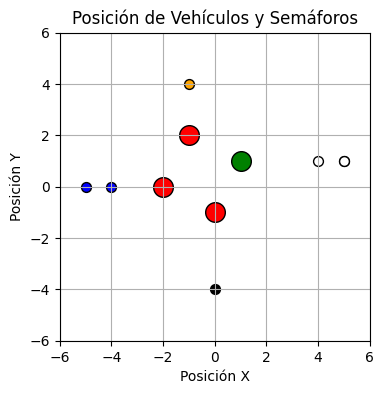

Completed: 1 steps----------------------------------------
{'traffic_lights': [{'id': 'N', 'state': 'red', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'red', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'green', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'red', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 4, 'y': 1, 'direction': (-1, 0)}, {'id': 1, 'x': 5, 'y': 1, 'direction': (-1, 0)}, {'id': 2, 'x': 5, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': 4, 'direction': (0, -1)}, {'id': 4, 'x': -4, 'y': 0, 'direction': (1, 0)}, {'id': 5, 'x': -5, 'y': 0, 'direction': (1, 0)}, {'id': 6, 'x': 0, 'y': -4, 'direction': (0, 1)}]}


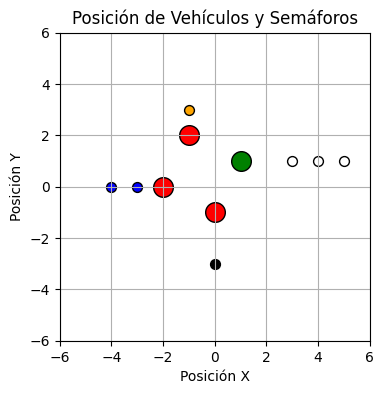

Completed: 2 steps----------------------------------------
{'traffic_lights': [{'id': 'N', 'state': 'red', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'red', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'green', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'red', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 3, 'y': 1, 'direction': (-1, 0)}, {'id': 1, 'x': 4, 'y': 1, 'direction': (-1, 0)}, {'id': 2, 'x': 5, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': 3, 'direction': (0, -1)}, {'id': 4, 'x': -3, 'y': 0, 'direction': (1, 0)}, {'id': 5, 'x': -4, 'y': 0, 'direction': (1, 0)}, {'id': 6, 'x': 0, 'y': -3, 'direction': (0, 1)}]}


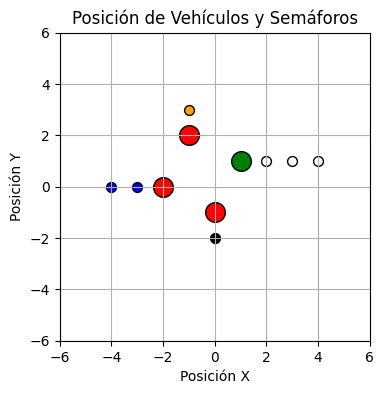

Completed: 3 steps----------------------------------------
{'traffic_lights': [{'id': 'N', 'state': 'red', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'red', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'green', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'red', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 2, 'y': 1, 'direction': (-1, 0)}, {'id': 1, 'x': 3, 'y': 1, 'direction': (-1, 0)}, {'id': 2, 'x': 4, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': 3, 'direction': (0, -1)}, {'id': 4, 'x': -3, 'y': 0, 'direction': (1, 0)}, {'id': 5, 'x': -4, 'y': 0, 'direction': (1, 0)}, {'id': 6, 'x': 0, 'y': -2, 'direction': (0, 1)}]}


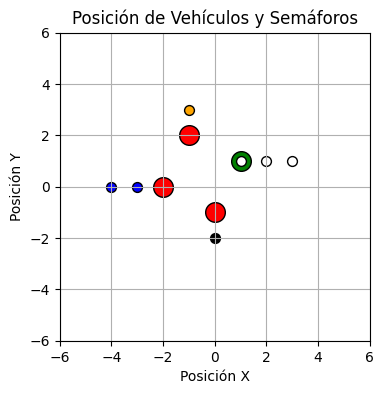

Completed: 4 steps----------------------------------------
{'traffic_lights': [{'id': 'N', 'state': 'red', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'red', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'green', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'red', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 1, 'y': 1, 'direction': (-1, 0)}, {'id': 1, 'x': 2, 'y': 1, 'direction': (-1, 0)}, {'id': 2, 'x': 3, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': 3, 'direction': (0, -1)}, {'id': 4, 'x': -3, 'y': 0, 'direction': (1, 0)}, {'id': 5, 'x': -4, 'y': 0, 'direction': (1, 0)}, {'id': 6, 'x': 0, 'y': -2, 'direction': (0, 1)}]}


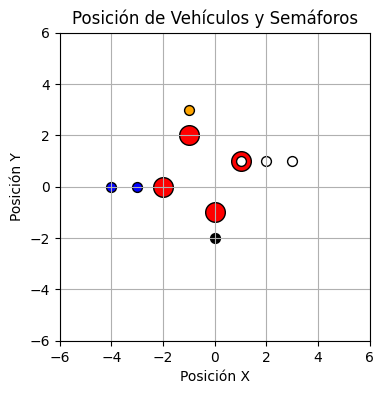

Completed: 5 steps----------------------------------------
{'traffic_lights': [{'id': 'N', 'state': 'red', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'red', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'red', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'red', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 1, 'y': 1, 'direction': (-1, 0)}, {'id': 1, 'x': 2, 'y': 1, 'direction': (-1, 0)}, {'id': 2, 'x': 3, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': 3, 'direction': (0, -1)}, {'id': 4, 'x': -3, 'y': 0, 'direction': (1, 0)}, {'id': 5, 'x': -4, 'y': 0, 'direction': (1, 0)}, {'id': 6, 'x': 0, 'y': -2, 'direction': (0, 1)}]}


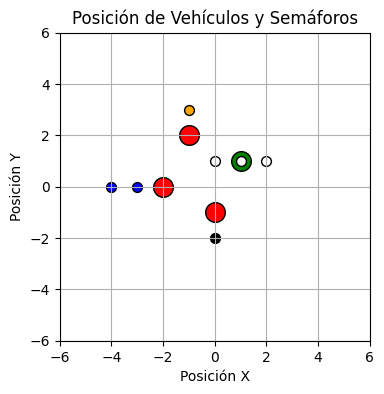

Completed: 6 steps----------------------------------------
{'traffic_lights': [{'id': 'N', 'state': 'red', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'red', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'green', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'red', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 0, 'y': 1, 'direction': (-1, 0)}, {'id': 1, 'x': 1, 'y': 1, 'direction': (-1, 0)}, {'id': 2, 'x': 2, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': 3, 'direction': (0, -1)}, {'id': 4, 'x': -3, 'y': 0, 'direction': (1, 0)}, {'id': 5, 'x': -4, 'y': 0, 'direction': (1, 0)}, {'id': 6, 'x': 0, 'y': -2, 'direction': (0, 1)}]}


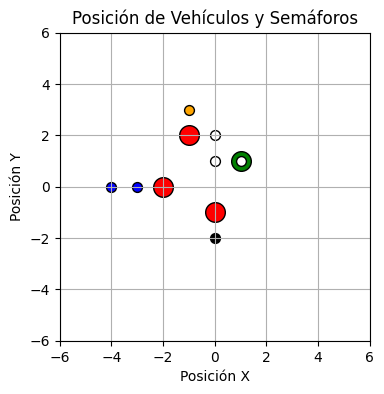

Completed: 7 steps----------------------------------------
{'traffic_lights': [{'id': 'N', 'state': 'red', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'red', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'green', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'red', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 0, 'y': 2, 'direction': (0, 1)}, {'id': 1, 'x': 0, 'y': 1, 'direction': (-1, 0)}, {'id': 2, 'x': 1, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': 3, 'direction': (0, -1)}, {'id': 4, 'x': -3, 'y': 0, 'direction': (1, 0)}, {'id': 5, 'x': -4, 'y': 0, 'direction': (1, 0)}, {'id': 6, 'x': 0, 'y': -2, 'direction': (0, 1)}]}


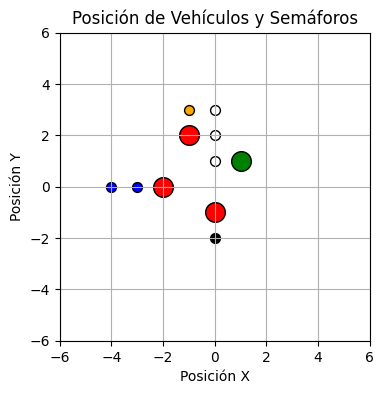

Completed: 8 steps----------------------------------------
{'traffic_lights': [{'id': 'N', 'state': 'red', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'red', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'green', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'red', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 0, 'y': 3, 'direction': (0, 1)}, {'id': 1, 'x': 0, 'y': 2, 'direction': (0, 1)}, {'id': 2, 'x': 0, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': 3, 'direction': (0, -1)}, {'id': 4, 'x': -3, 'y': 0, 'direction': (1, 0)}, {'id': 5, 'x': -4, 'y': 0, 'direction': (1, 0)}, {'id': 6, 'x': 0, 'y': -2, 'direction': (0, 1)}]}


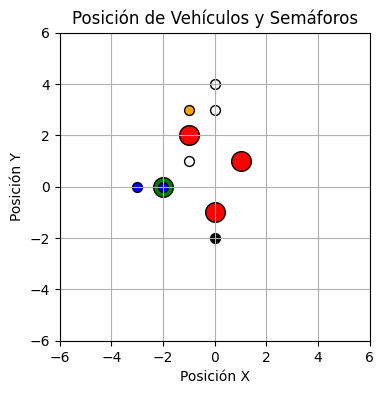

Completed: 9 steps----------------------------------------
{'traffic_lights': [{'id': 'N', 'state': 'red', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'red', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'red', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'green', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 0, 'y': 4, 'direction': (0, 1)}, {'id': 1, 'x': 0, 'y': 3, 'direction': (0, 1)}, {'id': 2, 'x': -1, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': 3, 'direction': (0, -1)}, {'id': 4, 'x': -2, 'y': 0, 'direction': (1, 0)}, {'id': 5, 'x': -3, 'y': 0, 'direction': (1, 0)}, {'id': 6, 'x': 0, 'y': -2, 'direction': (0, 1)}]}


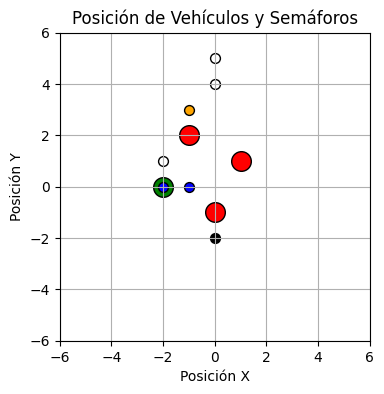

Completed: 10 steps----------------------------------------
{'traffic_lights': [{'id': 'N', 'state': 'red', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'red', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'red', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'green', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 0, 'y': 5, 'direction': (0, 1)}, {'id': 1, 'x': 0, 'y': 4, 'direction': (0, 1)}, {'id': 2, 'x': -2, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': 3, 'direction': (0, -1)}, {'id': 4, 'x': -1, 'y': 0, 'direction': (1, 0)}, {'id': 5, 'x': -2, 'y': 0, 'direction': (1, 0)}, {'id': 6, 'x': 0, 'y': -2, 'direction': (0, 1)}]}


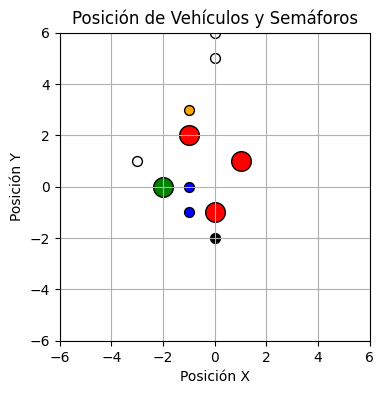

Completed: 11 steps----------------------------------------
{'traffic_lights': [{'id': 'N', 'state': 'red', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'red', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'red', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'green', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 0, 'y': 6, 'direction': (0, 1)}, {'id': 1, 'x': 0, 'y': 5, 'direction': (0, 1)}, {'id': 2, 'x': -3, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': 3, 'direction': (0, -1)}, {'id': 4, 'x': -1, 'y': -1, 'direction': (0, -1)}, {'id': 5, 'x': -1, 'y': 0, 'direction': (1, 0)}, {'id': 6, 'x': 0, 'y': -2, 'direction': (0, 1)}]}


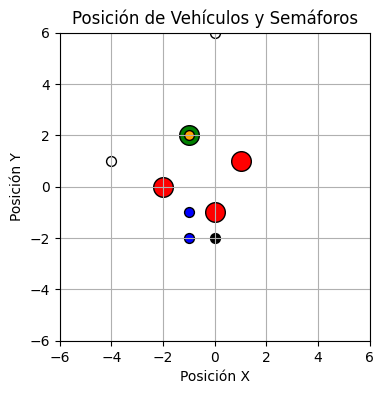

Completed: 12 steps----------------------------------------
{'traffic_lights': [{'id': 'N', 'state': 'green', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'red', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'red', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'red', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 0, 'y': 7, 'direction': (0, 1)}, {'id': 1, 'x': 0, 'y': 6, 'direction': (0, 1)}, {'id': 2, 'x': -4, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': 2, 'direction': (0, -1)}, {'id': 4, 'x': -1, 'y': -2, 'direction': (0, -1)}, {'id': 5, 'x': -1, 'y': -1, 'direction': (0, -1)}, {'id': 6, 'x': 0, 'y': -2, 'direction': (0, 1)}]}


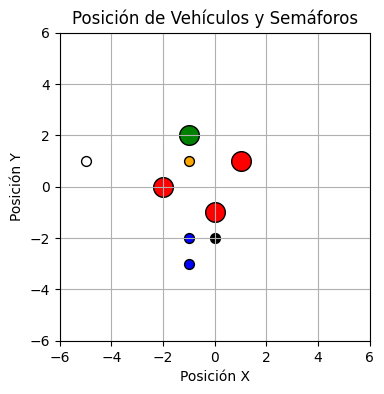

Completed: 13 steps----------------------------------------
{'traffic_lights': [{'id': 'N', 'state': 'green', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'red', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'red', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'red', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 0, 'y': 8, 'direction': (0, 1)}, {'id': 1, 'x': 0, 'y': 7, 'direction': (0, 1)}, {'id': 2, 'x': -5, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': 1, 'direction': (0, -1)}, {'id': 4, 'x': -1, 'y': -3, 'direction': (0, -1)}, {'id': 5, 'x': -1, 'y': -2, 'direction': (0, -1)}, {'id': 6, 'x': 0, 'y': -2, 'direction': (0, 1)}]}


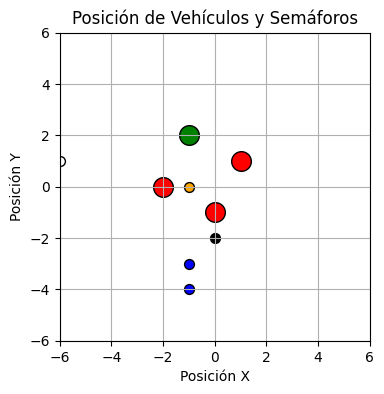

Completed: 14 steps----------------------------------------
{'traffic_lights': [{'id': 'N', 'state': 'green', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'red', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'red', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'red', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 0, 'y': 9, 'direction': (0, 1)}, {'id': 1, 'x': 0, 'y': 8, 'direction': (0, 1)}, {'id': 2, 'x': -6, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': 0, 'direction': (0, -1)}, {'id': 4, 'x': -1, 'y': -4, 'direction': (0, -1)}, {'id': 5, 'x': -1, 'y': -3, 'direction': (0, -1)}, {'id': 6, 'x': 0, 'y': -2, 'direction': (0, 1)}]}


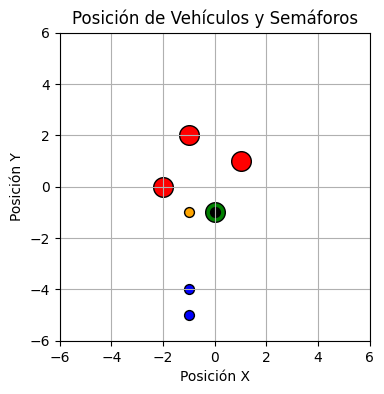

Completed: 15 steps----------------------------------------
{'traffic_lights': [{'id': 'N', 'state': 'red', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'green', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'red', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'red', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 0, 'y': 10, 'direction': (0, 1)}, {'id': 1, 'x': 0, 'y': 9, 'direction': (0, 1)}, {'id': 2, 'x': -7, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': -1, 'direction': (0, -1)}, {'id': 4, 'x': -1, 'y': -5, 'direction': (0, -1)}, {'id': 5, 'x': -1, 'y': -4, 'direction': (0, -1)}, {'id': 6, 'x': 0, 'y': -1, 'direction': (0, 1)}]}


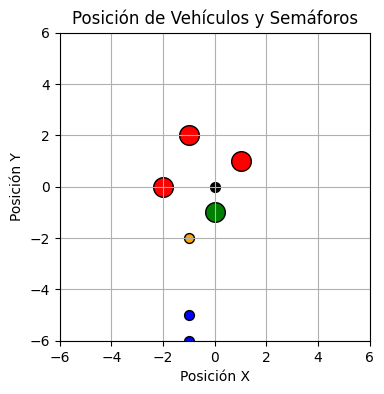

Completed: 16 steps----------------------------------------
{'traffic_lights': [{'id': 'N', 'state': 'red', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'green', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'red', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'red', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 0, 'y': 11, 'direction': (0, 1)}, {'id': 1, 'x': 0, 'y': 10, 'direction': (0, 1)}, {'id': 2, 'x': -8, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': -2, 'direction': (0, -1)}, {'id': 4, 'x': -1, 'y': -6, 'direction': (0, -1)}, {'id': 5, 'x': -1, 'y': -5, 'direction': (0, -1)}, {'id': 6, 'x': 0, 'y': 0, 'direction': (0, 1)}]}


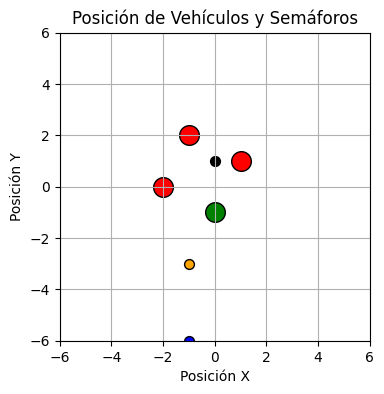

Completed: 17 steps----------------------------------------
{'traffic_lights': [{'id': 'N', 'state': 'red', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'green', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'red', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'red', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 0, 'y': 12, 'direction': (0, 1)}, {'id': 1, 'x': 0, 'y': 11, 'direction': (0, 1)}, {'id': 2, 'x': -9, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': -3, 'direction': (0, -1)}, {'id': 4, 'x': -1, 'y': -7, 'direction': (0, -1)}, {'id': 5, 'x': -1, 'y': -6, 'direction': (0, -1)}, {'id': 6, 'x': 0, 'y': 1, 'direction': (0, 1)}]}


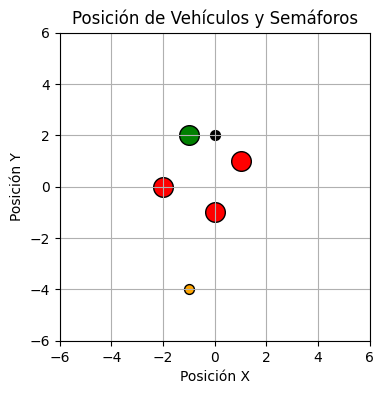

Completed: 18 steps----------------------------------------
{'traffic_lights': [{'id': 'N', 'state': 'green', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'red', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'red', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'red', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 0, 'y': 13, 'direction': (0, 1)}, {'id': 1, 'x': 0, 'y': 12, 'direction': (0, 1)}, {'id': 2, 'x': -10, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': -4, 'direction': (0, -1)}, {'id': 4, 'x': -1, 'y': -8, 'direction': (0, -1)}, {'id': 5, 'x': -1, 'y': -7, 'direction': (0, -1)}, {'id': 6, 'x': 0, 'y': 2, 'direction': (0, 1)}]}


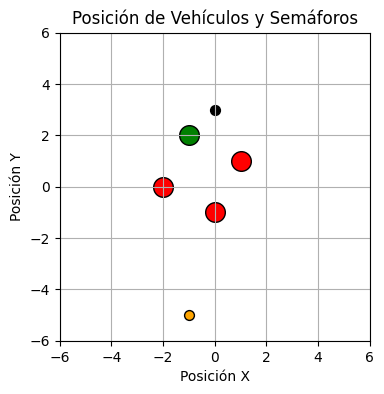

Completed: 19 steps----------------------------------------
{'traffic_lights': [{'id': 'N', 'state': 'green', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'red', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'red', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'red', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 0, 'y': 14, 'direction': (0, 1)}, {'id': 1, 'x': 0, 'y': 13, 'direction': (0, 1)}, {'id': 2, 'x': -11, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': -5, 'direction': (0, -1)}, {'id': 4, 'x': -1, 'y': -9, 'direction': (0, -1)}, {'id': 5, 'x': -1, 'y': -8, 'direction': (0, -1)}, {'id': 6, 'x': 0, 'y': 3, 'direction': (0, 1)}]}


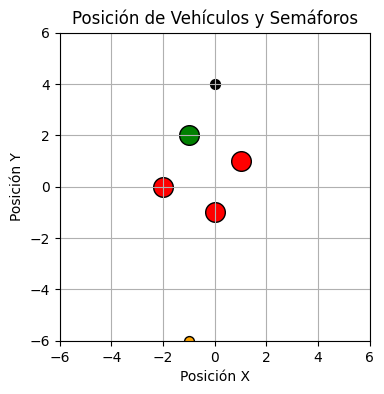

Completed: 20 steps[{'traffic_lights': [{'id': 'N', 'state': 'red', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'red', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'red', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'red', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 5, 'y': 1, 'direction': (-1, 0)}, {'id': 1, 'x': 5, 'y': 1, 'direction': (-1, 0)}, {'id': 2, 'x': 5, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': 5, 'direction': (0, -1)}, {'id': 4, 'x': -5, 'y': 0, 'direction': (1, 0)}, {'id': 5, 'x': -5, 'y': 0, 'direction': (1, 0)}, {'id': 6, 'x': 0, 'y': -5, 'direction': (0, 1)}]}, {'traffic_lights': [{'id': 'N', 'state': 'red', 'x': -1, 'y': 2}, {'id': 'S', 'state': 'red', 'x': 0, 'y': -1}, {'id': 'E', 'state': 'green', 'x': 1, 'y': 1}, {'id': 'O', 'state': 'red', 'x': -2, 'y': 0}], 'vehicles': [{'id': 0, 'x': 4, 'y': 1, 'direction': (-1, 0)}, {'id': 1, 'x': 5, 'y': 1, 'direction': (-1, 0)}, {'id': 2, 'x': 5, 'y': 1, 'direction': (-1, 0)}, {'id': 3, 'x': -1, 'y': 4, 'direction': (0, -1)}, {

In [5]:
class IntersectionModel(ap.Model):
    def setup(self):
        # Creación de semáforos con posiciones y carriles asignados
        traffic_lights_config = [
            {"id": "N", "position": (-1, 2), "carril": 1},
            {"id": "S", "position": (0, -1), "carril": 3},
            {"id": "E", "position": (1, 1), "carril": 2},
            {"id": "O", "position": (-2, 0), "carril": 0},
        ]

        self.traffic_lights = ap.AgentList(self, 0, TrafficLight)

        self.all_steps = []

        self.messages = []

        # Crea y añade cada semáforo a la lista
        for config in traffic_lights_config:
            light = TrafficLight(self)
            # Usar un método de configuración para inicializar atributos del semáforo
            light.setup(id=config["id"], position=config["position"], carril=config["carril"])
            self.traffic_lights.append(light)

        # Creación de vehículos, asignados aleatoriamente a un carril
        # num_vehicles = 1  # Supongamos que queremos empezar con 10 vehículos
        self.vehicles = ap.AgentList(self, self.p.n_vehicles, Vehicle)
        i = 0
        for vehicle in self.vehicles:
            vehicle.setup(i)
            i+=1

    def step(self):
        print("----------------------------------------")
        step_data = {
            "traffic_lights": [],
            "vehicles": []
        }

        for light in self.traffic_lights:
            step_data["traffic_lights"].append({"id": light.id, "state": light.state, "x": light.position[0], "y": light.position[1]})

        for vehicle in self.vehicles:
            # Suponiendo que vehicle.position es una tupla (x, y)
            step_data["vehicles"].append({"id": vehicle.id, "x": vehicle.position[0], "y": vehicle.position[1], "direction": vehicle.current_direction})

        self.all_steps.append(step_data)

        print(step_data)
        self.traffic_lights.step()
        self.auction()
        self.vehicles.step()

        plt.figure(figsize=(4, 4))
        for light in self.traffic_lights:
            if light.state == "green":
                plt.scatter(light.position[0], light.position[1], color='green', s=200, label='Semáforo Verde', edgecolors='black')
            elif light.state == "red":
                plt.scatter(light.position[0], light.position[1], color='red', s=200, label='Semáforo Rojo', edgecolors='black')
            elif light.state == "yellow":
                plt.scatter(light.position[0], light.position[1], color='yellow', s=200, label='Semáforo Amarillo', edgecolors='black')

        colors = ['blue', 'orange', 'white', 'black']
        for vehicle in self.vehicles:
            plt.scatter(vehicle.position[0], vehicle.position[1], color=colors[vehicle.carril], s=50, label='Vehículo', edgecolors='black')

        plt.xlim(-6, 6)
        plt.ylim(-6, 6)
        plt.grid(True)
        plt.xlabel('Posición X')
        plt.ylabel('Posición Y')
        plt.title('Posición de Vehículos y Semáforos')
        plt.show()

    def auction(self):
        # Procesar los mensajes para obtener el número de vehículos cercanos por semáforo
        vehicles_nearby_by_light = {}
        for msg in self.messages:
            _, vehicles_nearby, light_id = msg.strip("()").split(", ")
            vehicles_nearby_by_light[light_id] = int(vehicles_nearby)

        # Encuentra el ID del semáforo con el mayor número de vehículos cercanos
        highest_bid_id = max(vehicles_nearby_by_light, key=vehicles_nearby_by_light.get)

        # Verifica si el semáforo ganador puede ponerse en verde
        for tl in self.traffic_lights:
            if tl.id == highest_bid_id and tl.state == "red":
                tl.go_green()  # Pone en verde el semáforo ganador
            elif tl.id != highest_bid_id and tl.state == "green":
                tl.state = "red"  # Asegura que los demás semáforos están en rojo

        # Actualizar los estados de los semáforos
        for tl in self.traffic_lights:
            tl.update_state()

        # Limpiar los mensajes después de la subasta
        self.messages.clear()

    def end(self):
        print(self.all_steps)
        json_data = json.dumps({"steps": self.all_steps}, indent=4)
        with open('simulation_data.json', 'w') as json_file:
            json_file.write(json_data)


# Ejecución de la simulación
parameters = {
    'n_vehicles': 7
}
model = IntersectionModel(parameters)
results = model.run(steps=20)
